# Setup

In [ ]:
!pip install --upgrade --no-cache-dir git+https://github.com/StreamAlpha/tvdatafeed.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/StreamAlpha/tvdatafeed.git to /tmp/pip-req-build-8hf2stgq
  Running command git clone -q https://github.com/StreamAlpha/tvdatafeed.git /tmp/pip-req-build-8hf2stgq
     |████████████████████████████████| 55 kB 5.9 MB/s 
  Created wheel for tvdatafeed: filename=tvdatafeed-2.1.0-py3-none-any.whl size=7570 sha256=e34bfe503c38168471146ae7f2a9f504b1ce6a2d0e057b70767cd18e1d566913
  Stored in directory: /tmp/pip-ephem-wheel-cache-hiro3z8i/wheels/61/5f/7d/953ab2e3eaea9db6badc898aec3ff220779870e60932341e72
Successfully built tvdatafeed


In [ ]:
!pip install pykalman

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 228 kB 4.9 MB/s 
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48463 sha256=2c19ae872ceae384651e5a1f7d92d2b548bf34e6e6f2e09d2956f296ddf63203
  Stored in directory: /root/.cache/pip/wheels/11/16/21/615e29f0001ed6258b25d2a3a84ccfd65c5469b3505d4ab3ab
Successfully built pykalman


In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as stats
import pylab
from scipy.stats import norm

from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.tsa.vector_ar import vecm
from statsmodels.tsa.vector_ar import var_model
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa import stattools
from statsmodels.tsa.stattools import grangercausalitytests

from tvDatafeed import TvDatafeed, Interval

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
import statsmodels.tsa.stattools as ts

In [ ]:
#import hvplot.pandas
from pykalman import KalmanFilter

In [ ]:
# Usuario y contraseña de Tradingview
tv = TvDatafeed("usuario", "contraseña")

# Funciones

In [ ]:
def augmented_dickey_fuller(series, alfa = 0.05):
  # Must import stattools
  adf_results = stattools.adfuller(series.dropna(),autolag='AIC')
  data = list(adf_results[0:4])
  for key, val in adf_results[4].items():
    data.append(val)
  if adf_results[1] <= alfa:
    data.append("Reject the null hypothesis")
    data.append("Data has no unit root and is stationary")
  else:
    data.append("Fail to reject the null hypothesis")
    data.append("Data has a unit root and is non-stationary")
  adf_df = pd.DataFrame(data, index = ["ADF test statistic", "p-value", 
                                       "# lags used", "# observations ", 
                                       "critical value (1%)", "critical value (5%)",
                                       "critical value (10%)", f"Result (alfa={alfa})", "Conclusion"])
  return adf_df

In [ ]:
def grangers_causation_matrix(data, variables, maxlag = 5, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    df = df.T
    return df

In [ ]:
# Anualizar retornos

def annualize_ret(data, periods_per_year):
  ann_ret = ((data+1).prod())**(periods_per_year/data.shape[0])-1
  
  return ann_ret

In [ ]:
def joh_output(res):
  n_coint_vectors = []
  for i in res.ind:
    n_coint_vectors.append(f"At most {i}")
  output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"], columns= n_coint_vectors)
  print(output.T,'\n')
  print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
  print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')

In [ ]:
def calc_slope_intercept_kalman(etfs, prices, delta=1e-5):
    """
    Utilise the Kalman Filter from the pyKalman package
    to calculate the slope and intercept of the regressed
    ETF prices.
    """
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.vstack(
        [prices[etfs[0]], np.ones(prices[etfs[0]].shape)]
    ).T[:, np.newaxis]
    
    kf = KalmanFilter(
        n_dim_obs=1, 
        n_dim_state=2,
        initial_state_mean=np.zeros(2),
        initial_state_covariance=np.ones((2, 2)),
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        observation_covariance=1.0,
        transition_covariance=trans_cov
    )
    
    state_means, state_covs = kf.filter(prices[etfs[1]].values)
    return state_means, state_covs

In [ ]:
def draw_slope_intercept_changes(prices, state_means, size=(15, 8)):
    """
    Plot the slope and intercept changes from the 
    Kalman Filte calculated values.
    """
    pd.DataFrame(
        dict(
            slope=state_means[:, 0], 
            intercept=state_means[:, 1]
        ), index=prices.index
    ).plot(subplots=True)
    plt.gcf().set_size_inches(size)
    plt.show()

In [ ]:
def is_normal(uwu, alfa = 0.05):
  result = stats.jarque_bera(uwu)
  stat = result[0]
  pval = result[1]
  is_it = pval > alfa
  
  return stat, pval, is_it

# Importando la data

In [ ]:
chl_ipsa = tv.get_hist(symbol='SP_IPSA', exchange = "BCS" ,interval=Interval.in_daily ,n_bars=30000)["close"]
per_igbvl = tv.get_hist(symbol='SPBLPGPT', exchange = "BVL" ,interval=Interval.in_daily ,n_bars=30000)["close"]

chl_ipsa.index = chl_ipsa.index.to_period("D")
per_igbvl.index = per_igbvl.index.to_period("D")

In [ ]:
unido = pd.merge(chl_ipsa, per_igbvl, how = "left", left_index = True, right_index = True)

unido.columns = ["chl_ipsa", "per_igbvl"]

In [ ]:
latam_index = unido.dropna()
log_latam_index = np.log(latam_index)
returns_latam_index = log_latam_index.diff().dropna()

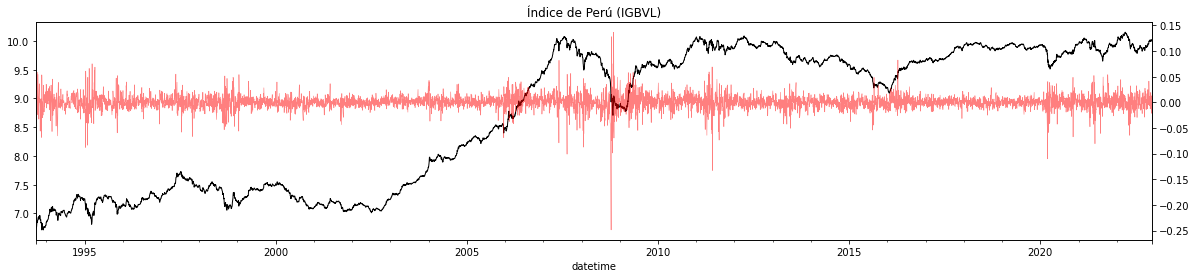

In [ ]:
plt.title("Índice de Perú (IGBVL)")
log_latam_index["per_igbvl"].plot(figsize=(20,4), color="black", linewidth = 1)
returns_latam_index["per_igbvl"].plot(color="red", linewidth = 0.6, secondary_y = True, alpha=0.5)

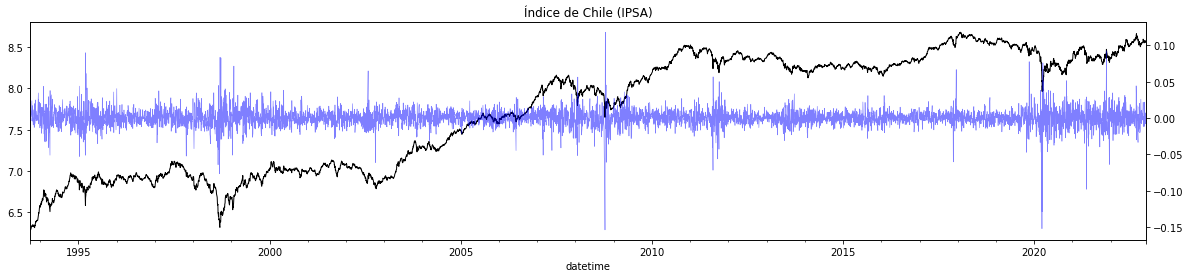

In [ ]:
plt.title("Índice de Chile (IPSA)")
log_latam_index["chl_ipsa"].plot(figsize=(20,4), color="black", linewidth = 1)
returns_latam_index["chl_ipsa"].plot(color="blue", linewidth = 0.6, secondary_y = True, alpha=0.5)

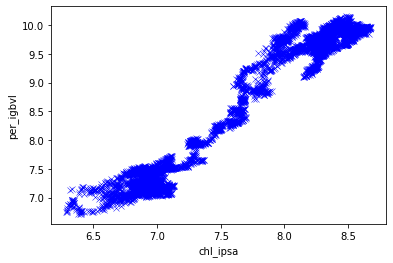

In [ ]:
sns.scatterplot(x=log_latam_index["chl_ipsa"], y=log_latam_index["per_igbvl"], marker="x", color = "blue")

Text(0, 0.5, 'per_igbvl')

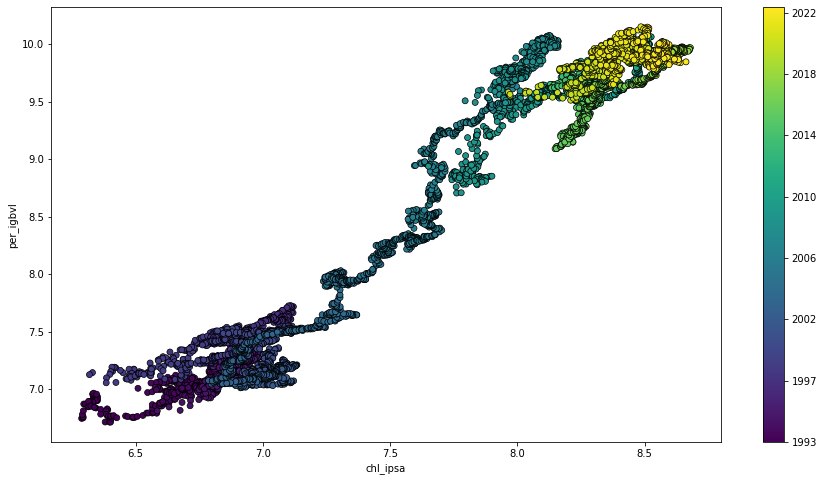

In [ ]:
fig, ax = plt.subplots()
smap = ax.scatter(log_latam_index["chl_ipsa"], log_latam_index["per_igbvl"], c=range(len(log_latam_index)), marker='o', edgecolors='black', linewidth=0.7)
cb = fig.colorbar(smap, orientation='vertical')
indexes = [log_latam_index.index[i] for i in np.linspace(0,log_latam_index.shape[0]-1,8).astype(int)]
cb.ax.set_yticklabels([index.strftime('%Y') for index in indexes])
plt.gcf().set_size_inches(15, 8)
plt.xlabel("chl_ipsa")
plt.ylabel("per_igbvl")

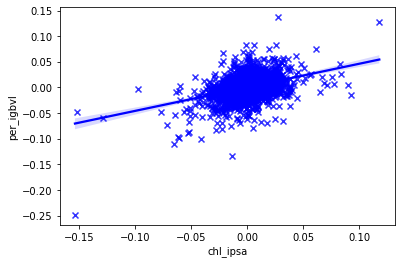

In [ ]:
sns.regplot(x=returns_latam_index["chl_ipsa"], y=returns_latam_index["per_igbvl"], marker="x", color = "blue")

# Data estacionalizada

In [ ]:
adf_to_data_diff = pd.DataFrame()
for i in returns_latam_index.columns:
  adf_to_data_diff[i] = augmented_dickey_fuller(returns_latam_index[i])
adf_to_data_diff

,chl_ipsa,per_igbvl
ADF test statistic,-17.055074,-16.833154
p-value,0.0,0.0
# lags used,27,20
# observations,7062,7069
critical value (1%),-3.431276,-3.431275
critical value (5%),-2.861949,-2.861949
critical value (10%),-2.566988,-2.566988
Result (alfa=0.05),Reject the null hypothesis,Reject the null hypothesis
Conclusion,Data has no unit root and is stationary,Data has no unit root and is stationary


# Prueba de Causalidad de Granger

In [ ]:
model_var = var_model.VAR(endog=returns_latam_index)
res = model_var.select_order(10)
res.summary()

,AIC,BIC,FPE,HQIC
0,-17.56,-17.55,2.376e-08,-17.55
1,-17.60,-17.60*,2.268e-08,-17.60
2,-17.60,-17.59,2.265e-08,-17.60
3,-17.61,-17.59,2.257e-08,-17.60*
4,-17.61,-17.59,2.256e-08,-17.60
5,-17.61,-17.59,2.257e-08,-17.60
6,-17.61,-17.58,2.257e-08,-17.60
7,-17.61,-17.58,2.256e-08,-17.60
8,-17.61,-17.57,2.256e-08,-17.60
9,-17.61*,-17.57,2.249e-08*,-17.60


In [ ]:
grangers_causation_matrix(returns_latam_index, returns_latam_index.columns, maxlag=1, test='ssr_chi2test', verbose=True)

Y = chl_ipsa, X = chl_ipsa, P Values = [1.0]
Y = per_igbvl, X = chl_ipsa, P Values = [0.0002]
Y = chl_ipsa, X = per_igbvl, P Values = [0.0008]
Y = per_igbvl, X = per_igbvl, P Values = [1.0]


,chl_ipsa_y,per_igbvl_y
chl_ipsa_x,1.0000,0.0002
per_igbvl_x,0.0008,1.0000


# Correlación

In [ ]:
returns_latam_index.corr()

,chl_ipsa,per_igbvl
chl_ipsa,1.000000,0.388313
per_igbvl,0.388313,1.000000


Correlación a lo largo del tiempo.

In [ ]:
w_uniform = np.repeat(1/len(returns_latam_index.columns),len(returns_latam_index.columns))
total_markets_returns = (w_uniform*returns_latam_index).sum(axis = 1)

In [ ]:
# Retornos compuestos anuales
rets_compuestos_12months = total_markets_returns.rolling(window = 252).aggregate(annualize_ret, 252).dropna()

# Correlación promedio anual
corr_12months = returns_latam_index.rolling(window = 252).corr()
corr_12months.index.names = ["Date", "Index"]
corr_promedio_12months = corr_12months.groupby("Date").mean().mean(axis = 1).dropna()

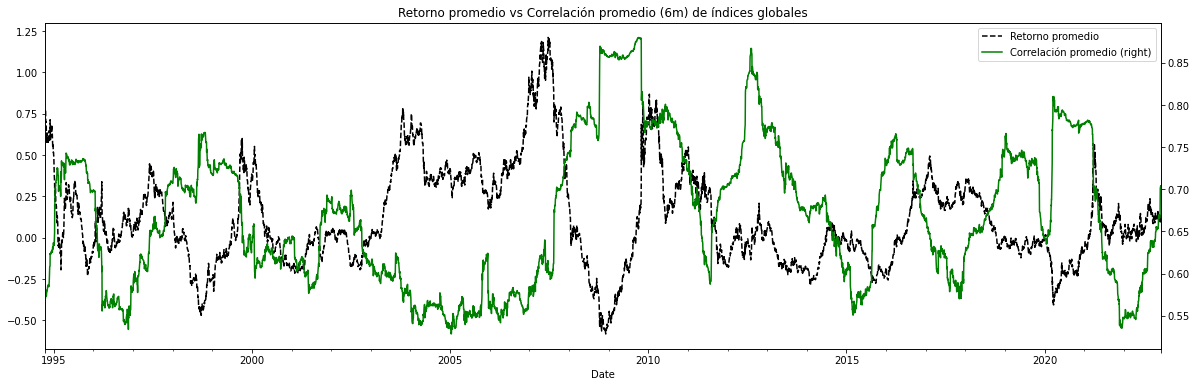

In [ ]:
plt.title("Retorno promedio vs Correlación promedio (6m) de índices globales")

s1 = rets_compuestos_12months.plot(figsize = (20,6), 
                              color = "black", 
                              label = "Retorno promedio", 
                              legend = True, style="--")

s2 = corr_promedio_12months.plot(  color = "green", 
                              label = "Correlación promedio",
                              legend = True,
                              secondary_y = True)

In [ ]:
corr_promedio_12months.corr(rets_compuestos_12months)

-0.4207934312389928

#Pruebas de cointegración

In [ ]:
joh_test = vecm.coint_johansen(log_latam_index, det_order = 1, k_ar_diff = 1)
joh_output(joh_test)

           max_eig_stat  trace_stat
At most 0     26.178587   27.580701
At most 1      1.402114    1.402114 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[15.0006 17.1481 21.7465]
 [ 2.7055  3.8415  6.6349]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[16.1619 18.3985 23.1485]
 [ 2.7055  3.8415  6.6349]] 



In [ ]:
model = vecm.select_order(log_latam_index,maxlags=10)
model.summary()

,AIC,BIC,FPE,HQIC
0,-17.56,-17.55,2.372e-08,-17.55
1,-17.60,-17.59*,2.264e-08,-17.60
2,-17.60,-17.59,2.262e-08,-17.60
3,-17.61,-17.59,2.254e-08,-17.60*
4,-17.61,-17.59,2.252e-08,-17.60
5,-17.61,-17.58,2.253e-08,-17.60
6,-17.61,-17.58,2.253e-08,-17.60
7,-17.61,-17.58,2.252e-08,-17.60
8,-17.61,-17.57,2.253e-08,-17.60
9,-17.61*,-17.57,2.246e-08*,-17.60


In [ ]:
# Prueba de la traza - Rank of VECM
vec_rank = vecm.select_coint_rank(log_latam_index, det_order = 1, k_ar_diff = 1, method = 'trace')
print(vec_rank.summary())

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   2          27.58          18.40
  1   2          1.402          3.841
-------------------------------------


In [ ]:
# Prueba de los autovalores - Rank of VECM
vec_rank1 = vecm.select_coint_rank(log_latam_index, det_order = 1, k_ar_diff = 1, method = 'maxeig')
print(vec_rank1.summary())

Johansen cointegration test using maximum eigenvalue test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          26.18          17.15
  1   2          1.402          3.841
-------------------------------------


# Modelo VECM & Impulso respuesta

Ecuación VECM

In [ ]:
model = vecm.VECM(log_latam_index, k_ar_diff=1,coint_rank=1,deterministic='co')
vecm_fit = model.fit()

In [ ]:
print(vecm_fit.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation chl_ipsa
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0080      0.003      2.880      0.004       0.003       0.013
L1.chl_ipsa      0.1533      0.013     12.013      0.000       0.128       0.178
L1.per_igbvl    -0.0368      0.011     -3.412      0.001      -0.058      -0.016
Det. terms outside the coint. relation & lagged endog. parameters for equation per_igbvl
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0053      0.003     -1.635      0.102      -0.012       0.001
L1.chl_ipsa      0.0553      0.015      3.673      0.000       0.026       0.085
L1.per_igbvl     0.1407      0.013     11.067      0.000       0.116       0.166
             

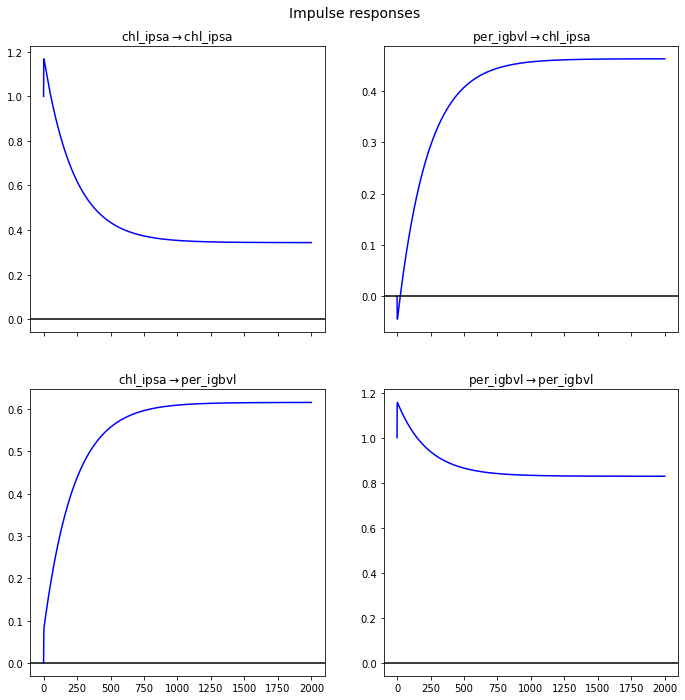

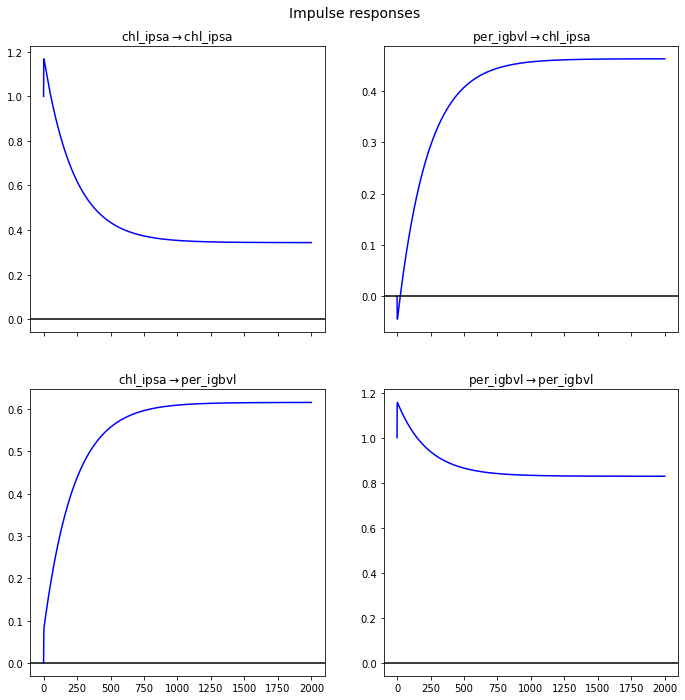

In [ ]:
ir = vecm_fit.irf(periods=2000)
ir.plot(plot_stderr=False)

# Residuos de cointegración

In [ ]:
formula = "per_igbvl ~ chl_ipsa"
results_ols =  smf.ols(formula, log_latam_index).fit()

In [ ]:
print(results_ols.summary())

                            OLS Regression Results                            
Dep. Variable:              per_igbvl   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                 1.473e+05
Date:                Sun, 11 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:43:51   Log-Likelihood:                -278.73
No. Observations:                7091   AIC:                             561.5
Df Residuals:                    7089   BIC:                             575.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.3759      0.034   -127.603      0.0

In [ ]:
residuals = results_ols.resid

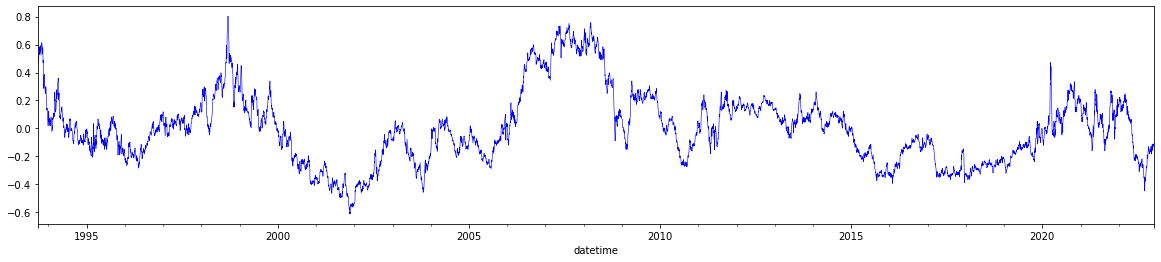

In [ ]:
residuals.plot(figsize=(20,4), color="blue", linewidth = 0.6)

In [ ]:
log_latam_index.head(1)

,chl_ipsa,per_igbvl
datetime,,
1993-09-27,6.287877,6.746095


In [ ]:
augmented_dickey_fuller(residuals)

,0
ADF test statistic,-4.105332
p-value,0.000949
# lags used,5
# observations,7085
critical value (1%),-3.431273
critical value (5%),-2.861948
critical value (10%),-2.566987
Result (alfa=0.05),Reject the null hypothesis
Conclusion,Data has no unit root and is stationary


In [ ]:
white_test = het_white(results_ols.resid,  results_ols.model.exog)

In [ ]:
print(dict(zip(['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value'],white_test)))

{'Test Statistic': 126.49403876104458, 'Test Statistic p-value': 3.4054027798515755e-28, 'F-Statistic': 64.36851025243301, 'F-Test p-value': 1.9767250205748974e-28}


# Kalman

In [ ]:
filtered = calc_slope_intercept_kalman(list(log_latam_index.columns), log_latam_index, delta=1e-4)

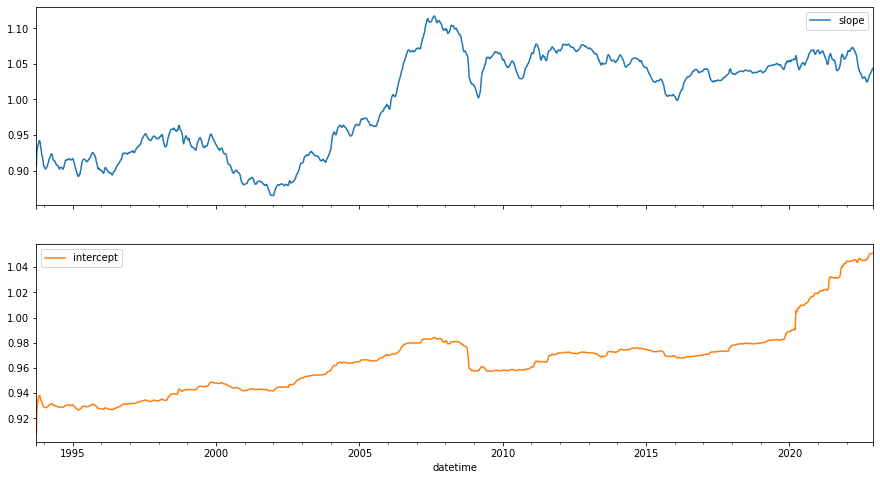

In [ ]:
# Cambios en el tiempo de los parámetros del vector de cointegración
draw_slope_intercept_changes(log_latam_index, filtered[0])

In [ ]:
kf_parameters = pd.DataFrame(filtered[0], columns = ["Slope", "Intercept"])
kf_parameters.index = log_latam_index.index

In [ ]:
residuals_filtered = log_latam_index["per_igbvl"] - kf_parameters["Intercept"] - kf_parameters["Slope"]*log_latam_index["chl_ipsa"]

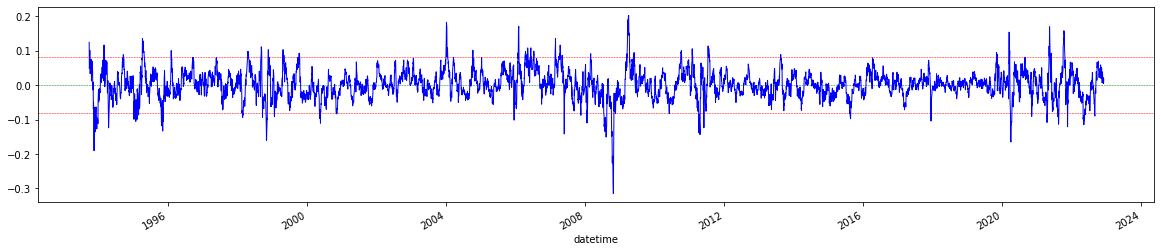

In [ ]:
plt.axhline(y=2*residuals_filtered.std(), color='red', linestyle='--', linewidth = 0.5)
plt.axhline(y=-2*residuals_filtered.std(), color='red', linestyle='--', linewidth = 0.5)
plt.axhline(y=residuals_filtered.mean(), color='green', linestyle='--', linewidth = 0.5)
residuals_filtered.plot(figsize=(20,4), color="blue", linewidth = 1)

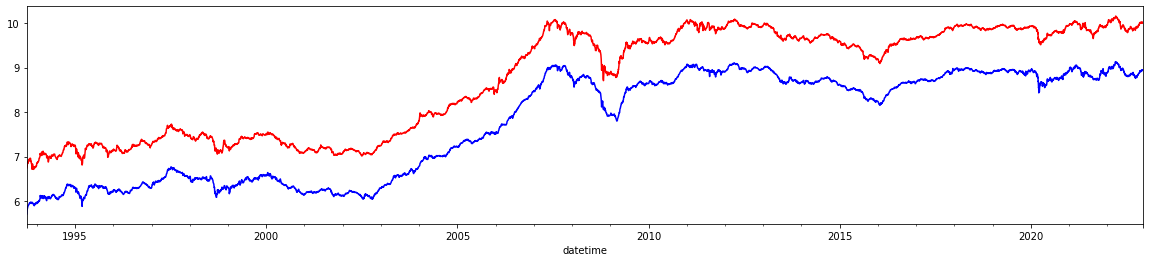

In [ ]:
log_latam_index["per_igbvl"].plot(figsize=(20,4), color = "r")
(log_latam_index["chl_ipsa"]*kf_parameters["Slope"]).plot(figsize=(20,4), color = "b")

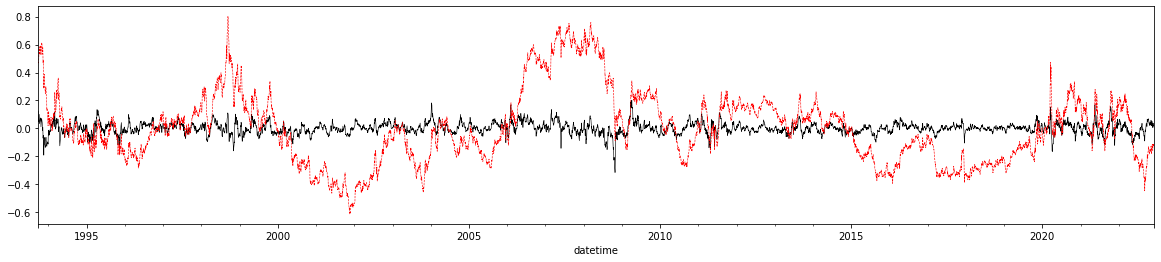

In [ ]:
# Comparación de los residuos de vector de coinegración fijo en el tiempo y uno correctivo en el tiempo
residuals_filtered.plot(figsize=(20,4), color="black", linewidth = 0.6)
residuals.plot(color="red", linewidth = 0.6, style="--")

In [ ]:
augmented_dickey_fuller(residuals_filtered)

,0
ADF test statistic,-15.528423
p-value,0.0
# lags used,5
# observations,7085
critical value (1%),-3.431273
critical value (5%),-2.861948
critical value (10%),-2.566987
Result (alfa=0.05),Reject the null hypothesis
Conclusion,Data has no unit root and is stationary


In [ ]:
mu, std = norm.fit(residuals_filtered)

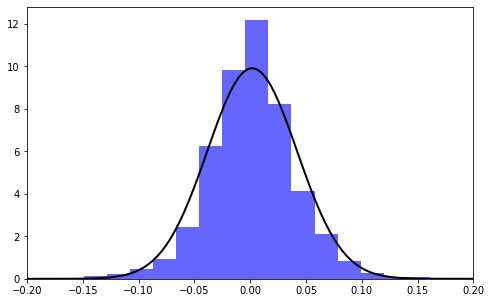

In [ ]:
plt.hist(residuals_filtered, bins=25, density=True, alpha=0.6, color='blue')
xmin, xmax = plt.xlim(-0.2,0.2)
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.gcf().set_size_inches(8, 5)
plt.plot(x, p, 'k', linewidth=2)

In [ ]:
is_normal(residuals_filtered)

(4431.800915723089, 0.0, False)

# Referencias



*   https://www.quantstart.com/articles/Dynamic-Hedge-Ratio-Between-ETF-Pairs-Using-the-Kalman-Filter/
*   https://medium.datadriveninvestor.com/kalman-filters-in-pairs-trading-dcf98a91a808
